The original KDD Cup 1999 dataset from UCI machine learning repository contains 41 attributes (34 continuous, and 7 categorical), however, they are reduced to 4 attributes (service, duration, src_bytes, dst_bytes) as these attributes are regarded as the most basic attributes (see kddcup.names), where only ‘service’ is categorical. Using the ‘service’ attribute, the data is divided into {http, smtp, ftp, ftp_data, others} subsets. Here, only ‘http’ service data is used. Since the continuous attribute values are concentrated around ‘0’, we transformed each value into a value far from ‘0’, by y = log(x + 0.1). The original data set has 3,925,651 class (80.1%) out of 4,898,431 records. A smaller set is forged by having only 3,377 class (0.35%) of 976,157 records, where attribute ‘logged_in’ is positive. From this forged dataset 567,497 ‘http’ service data is used to construct the http (KDDCUP99) dataset.

Description: X = Multi-dimensional point data, y = labels (1 = outliers, 0 = inliers)

http://odds.cs.stonybrook.edu/http-kddcup99-dataset/

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

import os
import time


from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import MeanShift
from sklearn.cluster import Birch
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import MiniBatchKMeans

from sklearn.model_selection import ParameterGrid

from sklearn.metrics import homogeneity_completeness_v_measure
from sklearn.metrics import homogeneity_score
from sklearn.metrics import completeness_score
from sklearn.metrics import v_measure_score
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score

import h2o


In [2]:
os.chdir(r"C:\Users\eanusau\Documents\AI\Stat\Projects\Clustering")

In [3]:
def print_version():
    print('pandas version:', pd.__version__)
    print('numpy version:', np.__version__)
    print('h2o version:', h2o.__version__)
    
print_version()


pandas version: 0.25.3
numpy version: 1.16.6
h2o version: 3.30.0.2


# dataset is in matlab file format

In [4]:
import hdf5storage
mat = hdf5storage.loadmat('datasets/http.mat')

In [5]:
X = mat.get('X')
y = mat.get('y')

In [6]:
X

array([[-2.30258509,  5.37110304, 10.71610745],
       [-2.30258509,  5.08821343,  8.4180577 ],
       [-2.30258509,  5.46425544,  7.11322354],
       ...,
       [-2.30258509,  5.38495367,  8.19149075],
       [-2.30258509,  5.38952825,  7.11809724],
       [-2.30258509,  5.38952825,  7.00133669]])

In [7]:
y.T

array([[0., 0., 0., ..., 0., 0., 0.]])

In [8]:
col_names = ['duration','src_bytes','dst_bytes','class']

In [9]:
data = np.concatenate((X, y), axis=1)

In [10]:
df = pd.DataFrame(data, columns=col_names)
df.head()

,duration,src_bytes,dst_bytes,class
0,-2.302585,5.371103,10.716107,0.0
1,-2.302585,5.088213,8.418058,0.0
2,-2.302585,5.464255,7.113224,0.0
3,-2.302585,5.451468,7.616825,0.0
4,-2.302585,5.476882,6.186414,0.0


In [11]:
df['class'] = df['class'].astype('int')

In [12]:
df.describe()

,duration,src_bytes,dst_bytes,class
count,567498.000000,567498.000000,567498.000000,567498.000000
mean,-2.268538,5.557679,7.489226,0.003896
std,0.465346,0.435007,1.316983,0.062297
min,-2.302585,-2.302585,-2.302585,0.000000
25%,-2.302585,5.380358,6.490875,0.000000
50%,-2.302585,5.517854,7.415235,0.000000
75%,-2.302585,5.723912,8.372884,0.000000
max,8.098369,10.906691,16.277711,1.000000


In [13]:
df.shape

(567498, 4)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567498 entries, 0 to 567497
Data columns (total 4 columns):
duration     567498 non-null float64
src_bytes    567498 non-null float64
dst_bytes    567498 non-null float64
class        567498 non-null int32
dtypes: float64(3), int32(1)
memory usage: 15.2 MB


In [15]:
percent_class = round(np.unique(df['class'], return_counts=True)[1][1]/df.shape[0] * 100, 2)
print(" count of normal events in original data:{}".format(np.unique(df['class'], return_counts=True)[1][0]))
print(" count of anamolies in original data:{}".format(np.unique(df['class'], return_counts=True)[1][1]))
print(" % of anamolies in original data:{}".format(percent_class))

 count of normal events in original data:565287
 count of anamolies in original data:2211
 % of anamolies in original data:0.39


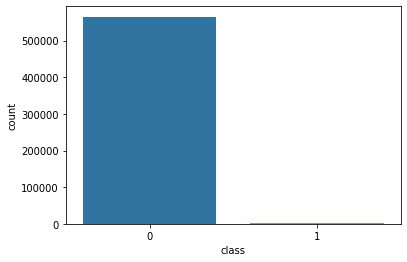

In [16]:
sns.countplot(x=df['class'], data=df)
plt.show()

## Density Plot and Histogram of predictors

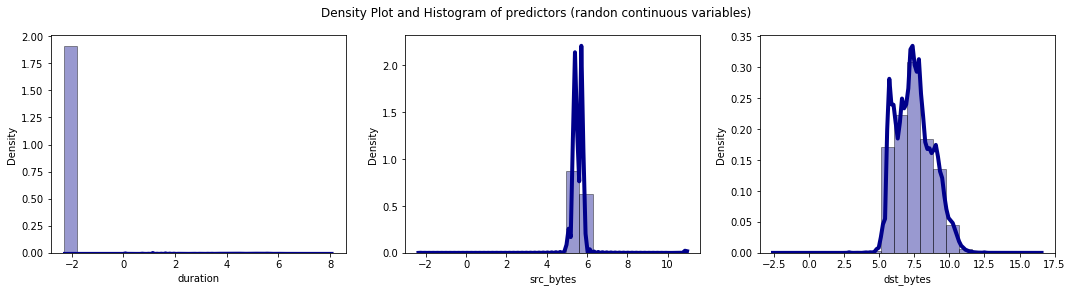

In [17]:
fig, ax = plt.subplots(1,3,figsize=(18, 4))

sns.distplot(df['duration'], ax=ax[0], hist=True, kde=True, 
             bins=int(100/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
ax[0].set(xlabel='duration', ylabel='Density')

sns.distplot(df['src_bytes'], ax=ax[1], hist=True, kde=True, 
             bins=int(100/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax[1].set(xlabel='src_bytes', ylabel='Density')



sns.distplot(df['dst_bytes'],ax=ax[2], hist=True, kde=True, 
             bins=int(100/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax[2].set(xlabel='dst_bytes', ylabel='Density')

plt.suptitle("Density Plot and Histogram of predictors (randon continuous variables)\n")
plt.show()

## we see src_bytes is strongly positively corelated with the target

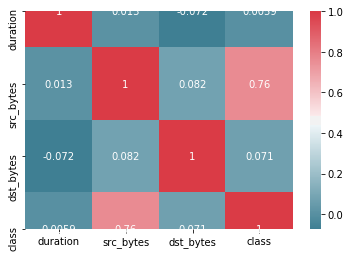

In [18]:
df_corr = df.corr()
sns.heatmap(df_corr, annot= True, cmap=sns.diverging_palette(220, 10, as_cmap=True))

## We see only few src_bytes below 4, so most probably they may be outliers

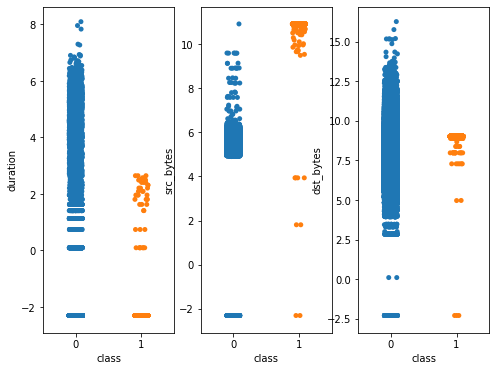

In [19]:
fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize=(8, 6))
sns.stripplot(y='duration',x='class', data=df, ax=ax1)
sns.stripplot(y='src_bytes',x='class', data=df, ax=ax2)
sns.stripplot(y='dst_bytes',x='class', data=df, ax=ax3)
plt.show()

In [20]:
http_features = df[['duration','src_bytes','dst_bytes']].values
http_labels = df['class'].values

In [21]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) Client VM (build 25.151-b12, mixed mode, sharing)
  Starting server from C:\Users\eanusau\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\eanusau\AppData\Local\Temp\tmpzr0t0yq4
  JVM stdout: C:\Users\eanusau\AppData\Local\Temp\tmpzr0t0yq4\h2o_eanusau_started_from_python.out
  JVM stderr: C:\Users\eanusau\AppData\Local\Temp\tmpzr0t0yq4\h2o_eanusau_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Asia/Kolkata
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.2
H2O_cluster_version_age:,17 days
H2O_cluster_name:,H2O_from_python_eanusau_vw0slr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,247.5 Mb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


In [22]:
df.to_csv('datasets/http.csv', index=False)

## load the dataset as h2o dataframe

In [23]:
df_h2o = h2o.import_file('datasets/http.csv')

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [24]:
df_h2o.head()

duration,src_bytes,dst_bytes,class
-2.30259,5.3711,10.7161,0
-2.30259,5.08821,8.41806,0
-2.30259,5.46426,7.11322,0
-2.30259,5.45147,7.61683,0
-2.30259,5.47688,6.18641,0
-2.30259,5.47269,7.15625,0
-2.30259,5.46001,7.19826,0
-2.30259,5.45575,7.21825,0
-2.30259,5.47688,7.16634,0
-2.30259,5.19905,8.60339,0


## make predictions using H2OIsolationForestEstimator

In [25]:
seed = 123
ntrees = 500
isoforest = h2o.estimators.H2OIsolationForestEstimator(
    ntrees=ntrees, seed=seed)
isoforest.train(x=df_h2o.col_names[0:3], training_frame=df_h2o)
predictions = isoforest.predict(df_h2o)

predictions

isolationforest Model Build progress: |███████████████████████████████████| 100%
isolationforest prediction progress: |████████████████████████████████████| 100%


predict,mean_length
0.306829,2.868
0.296539,2.89
0.109448,3.29
0.1029,3.304
0.105706,3.298
0.109448,3.29
0.114125,3.28
0.118803,3.27
0.11319,3.282
0.245089,3


In [26]:
predictions_df = predictions.as_data_frame()
predictions_df.head(3)

,predict,mean_length
0,0.306829,2.868
1,0.296539,2.890
2,0.109448,3.290


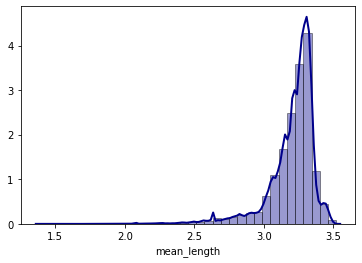

In [27]:
sns.distplot(predictions_df['mean_length'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.show()

## Lets select mean_length say 2.37 as threshold below which the data points are outlier

In [28]:
anomalies = df_h2o[predictions["mean_length"] < 2.37]
print("Number of Anomalies: " + str(anomalies.nrow))

Number of Anomalies: 2310


In [29]:
column_names = df_h2o.col_names[0:3]

In [30]:
column_names

['duration', 'src_bytes', 'dst_bytes']

In [31]:
isoforest.predict(anomalies)["mean_length"].cbind(anomalies[column_names])

isolationforest prediction progress: |████████████████████████████████████| 100%


mean_length,duration,src_bytes,dst_bytes
2.356,4.09601,5.31861,6.04997
2.244,5.30876,5.77175,6.04997
2.308,4.39568,5.29381,6.1401
2.334,-2.30259,5.11259,12.4912
2.18,-2.30259,5.0113,12.4912
2.072,1.1314,4.94947,9.71819
2.35,4.62595,5.3038,7.86829
2.224,5.24228,5.76237,7.86829
2.368,-2.30259,4.96354,10.3144
2.368,-2.30259,4.96354,10.3144


## Lets analyse at the global level the reason for data points being an anamoly

In [32]:
global_surrogate_data = df_h2o[:, :]
global_surrogate_data["anomaly"] = (predictions["mean_length"] < 2.37).ifelse("Yes", "No")
global_surrogate_data["anomaly"].table()

anomaly,Count
No,565188
Yes,2310


In [33]:
from h2o.estimators import H2ORandomForestEstimator

global_surrogate_dt = H2ORandomForestEstimator(model_id = "global_surrogate_decision_tree.hex", 
                                               ntrees = 1, max_depth = 3,
                                               sample_rate = 1, mtries = len(column_names))
global_surrogate_dt.train(training_frame = global_surrogate_data, x = column_names, y = "anomaly")

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [34]:
import os
import subprocess
from IPython.display import Image
def generateTreeImage(decision_tree, image_file_path):
    # Download MOJO
    mojo_path = decision_tree.download_mojo(get_genmodel_jar=True)
    directory = os.path.dirname(mojo_path)
    h2o_jar_path = os.path.join(directory, "h2o-genmodel.jar")
    # Create Graphviz file
    gv_file_path = os.path.join(directory, "decision_tree.gv")
    gv_call = " ".join(["java", "-cp", h2o_jar_path, "hex.genmodel.tools.PrintMojo", "--tree 0 -i", mojo_path , "-o", gv_file_path])
    result = subprocess.call(gv_call, shell=True)
    result = subprocess.call(["ls", gv_file_path], shell = True)
    result = subprocess.call(["dot", "-Tpng", gv_file_path, "-o", image_file_path], shell=True)
    result = subprocess.call(["ls",image_file_path], shell = True)
    
    return Image(image_file_path)

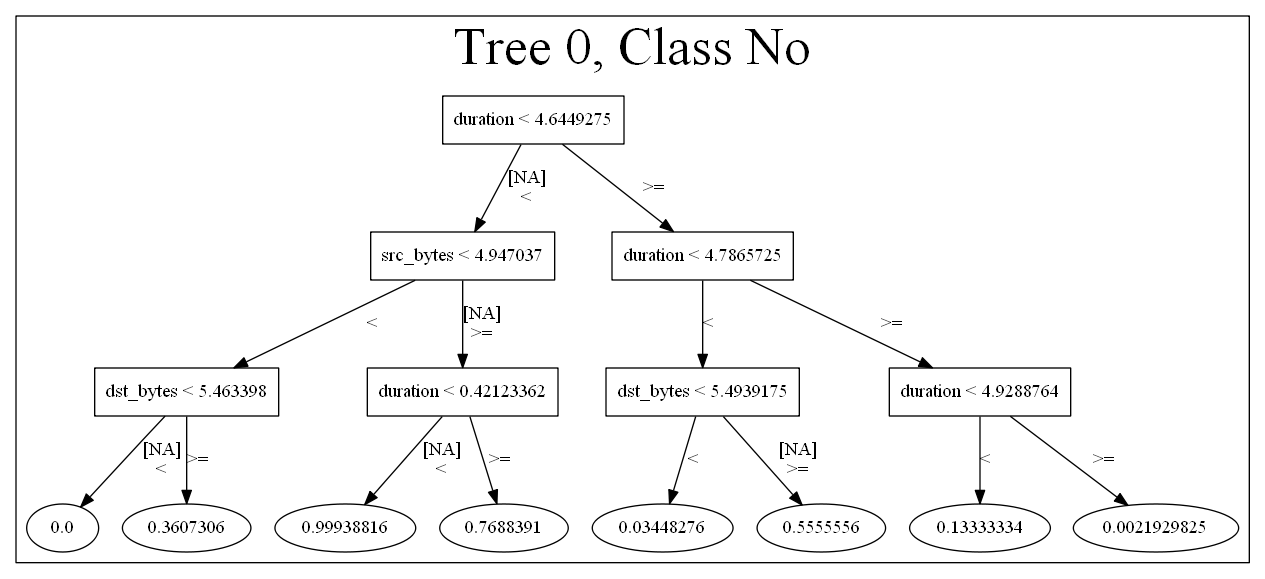

In [35]:
generateTreeImage(global_surrogate_dt, "./global_surrogate_decision_tree_http.png")

####  leaves with 0 values are outliers. To summarize, duration < 4.644 , src_bytes< 4.947 and dst_bytes < 5.46 together constitute outliers at global scale. Same can also be verified with stripplot plotted earlier

In [46]:
quantile = 0.97
quantile_frame = predictions.quantile([quantile])
quantile_frame

Probs,predictQuantiles,mean_lengthQuantiles,predicted_classQuantiles,classQuantiles
0.97,0.363891,3.41,1,0


We can use the threshold to predict the anomalous class. Try with different values of threshold 

In [47]:
threshold = quantile_frame[0, "predictQuantiles"]
predictions["predicted_class"] = predictions["predict"] > threshold
predictions["class"] = df_h2o["class"]
predictions

predict,mean_length,predicted_class,class
0.306829,2.868,0,0
0.296539,2.89,0,0
0.109448,3.29,0,0
0.1029,3.304,0,0
0.105706,3.298,0,0
0.109448,3.29,0,0
0.114125,3.28,0,0
0.118803,3.27,0,0
0.11319,3.282,0,0
0.245089,3,0,0


# Evaluation

Because the isolation forest is an unsupervised method, it makes sense to have a look at the classification metrics that are not dependent on the prediction threshold and give an estimate of the quality of scoring. Two such metrics are Area Under the Receiver Operating Characteristic Curve (AUC) and Area under the Precision-Recall Curve (AUCPR).

AUC is a metric evaluating how well a binary classification model distinguishes true positives from false positives. The perfect AUC score is 1; the baseline score of a random guessing is 0.5.

AUCPR is a metric evaluating the precision recall trade-off of a binary classification using different thresholds of the continuous prediction score. The perfect AUCPR score is 1; the baseline score is the relative count of the positive class.

For highly imbalanced data, AUCPR is recommended over AUC as the AUCPR is more sensitive to True positives, False positives and False negatives, while not caring about True negatives, which in large quantity usually overshadow the effect of other metrics.

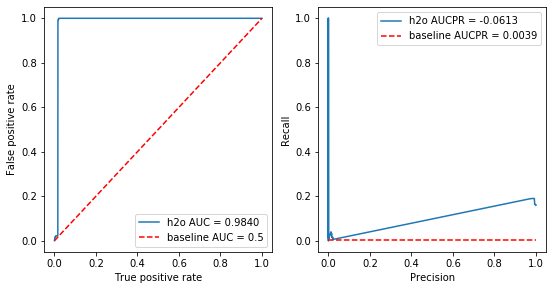

In [48]:
%matplotlib inline
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
import numpy as np


def get_auc(labels, scores):
    fpr, tpr, thresholds = roc_curve(labels, scores)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score


def get_aucpr(labels, scores):
    precision, recall, th = precision_recall_curve(labels, scores)
    aucpr_score = np.trapz(recall, precision)
    return precision, recall, aucpr_score


def plot_metric(ax, x, y, x_label, y_label, plot_label, style="-"):
    ax.plot(x, y, style, label=plot_label)
    ax.legend()
    
    ax.set_ylabel(x_label)
    ax.set_xlabel(y_label)


def prediction_summary(labels, predicted_score, predicted_class, info, plot_baseline=True, axes=None):
    if axes is None:
        axes = [plt.subplot(1, 2, 1), plt.subplot(1, 2, 2)]

    fpr, tpr, auc_score = get_auc(labels, predicted_score)
    plot_metric(axes[0], fpr, tpr, "False positive rate",
                "True positive rate", "{} AUC = {:.4f}".format(info, auc_score))
    if plot_baseline:
        plot_metric(axes[0], [0, 1], [0, 1], "False positive rate",
                "True positive rate", "baseline AUC = 0.5", "r--")

    precision, recall, aucpr_score = get_aucpr(labels, predicted_score)
    plot_metric(axes[1], recall, precision, "Recall",
                "Precision", "{} AUCPR = {:.4f}".format(info, aucpr_score))
    if plot_baseline:
        thr = sum(labels)/len(labels)
        plot_metric(axes[1], [0, 1], [thr, thr], "Recall",
                "Precision", "baseline AUCPR = {:.4f}".format(thr), "r--")

    plt.show()
    return axes


def figure():
    fig_size = 4.5
    f = plt.figure()
    f.set_figheight(fig_size)
    f.set_figwidth(fig_size*2)


h2o_predictions = predictions.as_data_frame()

figure()
axes = prediction_summary(
    h2o_predictions["class"], h2o_predictions["predict"], h2o_predictions["predicted_class"], "h2o")


[[550606  14681]
 [     0   2211]]


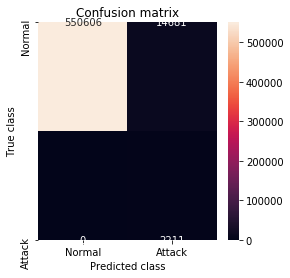

In [49]:
from sklearn.metrics import confusion_matrix
LABELS = ['Normal','Attack']
conf_matrix = confusion_matrix(h2o_predictions["class"], h2o_predictions["predicted_class"])
print(conf_matrix)
plt.figure(figsize=(4,4))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()


# [[539473  25814]
#  [    15   2196]]

# 2.2
# [[564309    978]
#  [  2194     17]]

# 3.44
# [[511945  53342]
#  [     0   2211]]

# 3.52
# [[555043  10244]
#  [  2164     47]]

In [50]:
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_fscore_support

print("f1_score: %.2f" % f1_score(h2o_predictions["class"], h2o_predictions["predicted_class"]))
print("average_precision_score: %.2f" % average_precision_score(h2o_predictions["class"], h2o_predictions["predicted_class"]))
print("recall_score: %.2f" % recall_score(h2o_predictions["class"], h2o_predictions["predicted_class"]))
print("precision_score: %.2f" % precision_score(h2o_predictions["class"], h2o_predictions["predicted_class"]))
   

f1_score: 0.23
average_precision_score: 0.13
recall_score: 1.00
precision_score: 0.13
